In [0]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 8 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 2s (59.7 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 110842 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-2) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack 

In [0]:
#importing important libraries

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
from keras import layers
from keras import models
from keras import applications
from keras import optimizers
from keras import callbacks


Using TensorFlow backend.


In [0]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials



In [0]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [0]:
# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass


In [0]:
# Auto-iterate using the query syntax
file_list = drive.ListFile(
    {'q': "'1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5' in parents"}).GetList()


In [0]:
#create a list of titles of .tif files downloaded

titles = []
for f in file_list:
  titles.append(f['title'])
  fname = os.path.join(local_download_path, f['title'])
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)
  
  


In [0]:
#separate the mask titles from the slide titles

slide_titles = []
mask_titles = []

for title in titles:
  if title.endswith('mask.tif'):
    mask_titles.append(title)
  elif title.endswith('.tif'):
    slide_titles.append(title)
    
#removing slide that doesn't have a corresponding mask

slide_titles.remove('tumor_038.tif')
    
    

In [0]:
#set aside a slide for testing later on

slide_titles.remove('tumor_091.tif')
mask_titles.remove('tumor_091_mask.tif')

In [0]:
#getting local paths for the slides and masks

slide_paths = []
tumor_mask_paths = []

for title in slide_titles:
  slide_paths.append('/root/data/%s' %title)
  
for title in mask_titles:
  tumor_mask_paths.append('/root/data/%s' %title)
  

In [0]:
#defining a function to read any slides/masks and return them as arrays

def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [0]:
#defining some helper functions to get the tissue density in a slide and to apply a monotone mask on an image

def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])
  

def apply_mask(im, mask, color):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked



In [0]:
#getting the openSlide objects for the slides and their masks

slides = []
masks = []

for path in slide_paths:
  slides.append(open_slide(path))
for path in tumor_mask_paths:
  masks.append(open_slide(path))

In [0]:
#getting 80x80 patches of the slides and masks by first converting the openSlide objects to numpy arrays, and sliding a window over them
#as for pre-processing of images:
#1. Throw away slides if they don't have any tumor cells in them. Many of the slides are actually empty, and don't even have any tissue. 
#2. for each patch, check the percentage tissue in that patch, only consider it if percentage tissue > 10

patches = []
tumor_patches = []

for k,slide in enumerate(slides):
  
  mask_image = read_slide(masks[k],x=0,y=0,level = 7, width=masks[k].level_dimensions[7][0], height=masks[k].level_dimensions[7][1])

  if np.count_nonzero(mask_image) > 0:  #checks if there actually is tumor in the slide
    
    for j in range(0,slide.level_dimensions[7][1],80):
      for i in range(0,slide.level_dimensions[7][0],80):
        patch = read_slide(slide,i*128,j*128,level = 7, width = 80,height = 80) #patch from slide
        mask_patch = read_slide(masks[k],i*128,j*128,level = 7, width = 80,height = 80)  #corresponding patch from mask
        tumor_patch = mask_patch[:,:,0] #take only one channel of mask
        tissue_pixels = find_tissue_pixels(patch) #find how many tissue pixels are there slide patch
        tissue_pixels = list(tissue_pixels)
        percent_tissue = len(tissue_pixels) / float(patch.shape[0] * patch.shape[0]) * 100 #percentage tissue in the patch
        if percent_tissue > 10:  #check if percent tissue is more than 10, if yes, then append both the slide patch and mask patch
          patches.append(patch)
          tumor_patches.append(tumor_patch)

  
    

In [0]:
#check if the number of slide patches and the number of patches from the masks correspond
assert len(patches) == len(tumor_patches)

In [0]:
#convert both lists to numpy arrays

patches = np.array(patches)
tumor_patches = np.array(tumor_patches)



In [0]:
#assigning labels to each patch: 1 if there is at least one non-zero entry in the corresponding mask patch, 0 if not. 

labels = []

for array in tumor_patches:
  if np.count_nonzero(array) > 0:
    labels.append(1)
  else :
    labels.append(0)
    

In [0]:
#converting to numpy array
labels = np.array(labels)

In [0]:
#checking the indices where the labels are 1
np.where(labels == 1)

(array([   4,    5,    6,    9,   10,   11,   16,   17,   22,   23,   26,
          27,   30,   34,   38,   39,   53,   54,   56,   57,   58,   59,
          60,   64,   65,   66,   67,   68,   69,   73,   74,   75,   77,
          78,   82,   83,   84,   85,   86,   91,   92,   93,  103,  104,
         109,  110,  119,  120,  164,  165,  172,  173,  178,  227,  241,
         242,  246,  247,  251,  252,  287,  322,  323,  327,  328,  333,
         334,  340,  341,  342,  348,  349,  351,  352,  354,  355,  356,
         359,  360,  362,  363,  364,  365,  367,  368,  371,  372,  373,
         374,  375,  376,  378,  379,  380,  381,  382,  384,  385,  398,
         399,  411,  412,  416,  417,  443,  451,  452,  453,  459,  460,
         462,  468,  469,  511,  567,  570,  608,  614,  660,  662,  663,
         666,  667,  670,  671,  672,  699,  700,  709,  717,  747,  748,
         804,  805,  808,  809,  810,  812,  813,  843,  897,  944, 1030,
        1031, 1036]),)

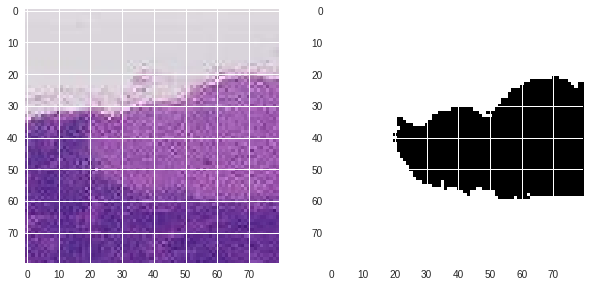

In [0]:
#plotting slide patch and mask patch at one of the above indices to see if the labels make sense
plt.figure(figsize= (10,5))
plt.subplot(1, 2, 1)
plt.imshow(patches[9]) 
plt.subplot(1,2,2)
plt.imshow(tumor_patches[9])


In [0]:
#number of positive samples
len(labels[labels == 1]) 

145

In [0]:
#number of negative samples
len(labels[labels == 0])

911

In [0]:
#defining success metric: f1 score

from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))





In [0]:
#defining model: InceptionV3 architecture with no pre-defined weights. 

conv_base = applications.inception_v3.InceptionV3(weights=None,include_top = False,input_shape=(80,80,3))
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))



In [0]:
#defining optimizer and compiling model

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy',optimizer=sgd,metrics=[f1])


In [0]:
!pip install sklearn

In [0]:
#dividing data into train and test
import sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(patches, labels,
                                                    stratify=labels, 
                                                    test_size=0.3)




In [0]:
#upsampling the minority class and making both classes equal in the training set only

# Indicies of each class' observations
i_class0 = np.where(y_train == 0)[0]
i_class1 = np.where(y_train == 1)[0]

# Number of observations in each class
n_class0 = len(i_class0)
n_class1 = len(i_class1)

# For every observation in class 1, randomly sample from class 1 with replacement
i_class1_upsampled = np.random.choice(i_class1, size=n_class0, replace=True)

# Join together class 0's upsampled target vector with class 0's target vector
np.concatenate((y_train[i_class1_upsampled], y_train[i_class0]))


array([1, 1, 1, ..., 0, 0, 0])

In [0]:
#number of samples of majority class in training set
len(i_class0)

638

In [0]:
#upsampled minory class 
X_train_upsampled = X_train[i_class1_upsampled]

In [0]:
X_train_0 = list(X_train[i_class0])
X_train_upsampled = list(X_train_upsampled)

In [0]:
#check if the upsampled class now has the same number of samples as the majority class
len(X_train_upsampled)

638

In [0]:
#appending the upsampled minority class to the training set to get a balanced set
for array in X_train_upsampled:
  X_train_0.append(array)


In [0]:
len(X_train_0) #upsampled

1276

In [0]:
y_train_upsampled = list(y_train[i_class1_upsampled])
y_train_0 = list(y_train[i_class0])

In [0]:
for array in y_train_upsampled:
  y_train_0.append(array)


In [0]:
len(y_train_0) #upsampled

1276

In [0]:
#define the new training samples and labels
X_train = np.array(X_train_0)
y_train = np.array(y_train_0)

In [0]:
X_train.shape

(1276, 80, 80, 3)

In [0]:
#training the data: f1 score is high here because the training data is perfectly balanced, but that is not the true representation of the data

callbacks = callbacks.EarlyStopping(monitor='loss', min_delta=0.1)
model.fit(X_train, y_train, epochs=10 ,callbacks = [callbacks], shuffle = True)

Epoch 1/10
1276/1276 [==============================] - 39s 30ms/step - loss: 0.5716 - f1: 0.6859
Epoch 2/10
1276/1276 [==============================] - 11s 9ms/step - loss: 0.4539 - f1: 0.7936
Epoch 3/10
1276/1276 [==============================] - 10s 8ms/step - loss: 0.4368 - f1: 0.7940


In [0]:
#since th actual data is quite imbalanced, the f1 score on the test set is quite low, but better that what was acheived with other models

model.evaluate(X_test,y_test)

317/317 [==============================] - 3s 11ms/step


[0.4026943191368873, 0.5208399107779614]

In [0]:
#visualizing predictions on a test slide
test_slide_path = '/root/data/tumor_091.tif'
test_slide = open_slide(test_slide_path)




In [0]:
#slide dimensions at level 7
test_slide.level_dimensions[7]

(480, 420)

In [0]:
#extracting patches from the test slide
test_slide_patches = []
for j in range(0,test_slide.level_dimensions[7][1],80):
  for i in range(0,test_slide.level_dimensions[7][0],80):
    image = read_slide(test_slide,i*128,j*128,level = 7, width = 80,height = 80)
    tissue_pixels = find_tissue_pixels(image)
    image = apply_mask(image, tissue_pixels, (255,0,0))
    test_slide_patches.append(image)


In [0]:
#converting into numpy array
test_slide_patches = np.array(test_slide_patches)

In [0]:
#predictions on test patches
predictions = model.predict(test_slide_patches)

In [0]:
predictions

array([[0.4588207 ],
       [0.4403698 ],
       [0.44926366],
       [0.603834  ],
       [0.44715324],
       [0.4510427 ],
       [0.44395632],
       [0.52806747],
       [0.7484174 ],
       [0.7399755 ],
       [0.72405267],
       [0.4546303 ],
       [0.453812  ],
       [0.7539893 ],
       [0.75449353],
       [0.73073936],
       [0.7305724 ],
       [0.58161956],
       [0.44601086],
       [0.74426675],
       [0.7476981 ],
       [0.7396717 ],
       [0.7318246 ],
       [0.46517485],
       [0.4607317 ],
       [0.57426715],
       [0.7576721 ],
       [0.525259  ],
       [0.6396197 ],
       [0.6286062 ],
       [0.6963866 ],
       [0.69819856],
       [0.6967047 ],
       [0.69870234],
       [0.72823995],
       [0.7344183 ]], dtype=float32)

In [0]:
#removing last 6 predictions because those patches don't actually belong to the slide - there are 36 predictions for 80x80 patches taken of a 480x420 image
predictions = predictions[:30]


In [0]:
predictions.shape

(30, 1)

In [0]:
#re-shaping to get the same orientation as that of the slide image
predictions = predictions.reshape((5,6))

In [0]:
predictions

array([[0.4588207 , 0.4403698 , 0.44926366, 0.603834  , 0.44715324,
        0.4510427 ],
       [0.44395632, 0.52806747, 0.7484174 , 0.7399755 , 0.72405267,
        0.4546303 ],
       [0.453812  , 0.7539893 , 0.75449353, 0.73073936, 0.7305724 ,
        0.58161956],
       [0.44601086, 0.74426675, 0.7476981 , 0.7396717 , 0.7318246 ,
        0.46517485],
       [0.4607317 , 0.57426715, 0.7576721 , 0.525259  , 0.6396197 ,
        0.6286062 ]], dtype=float32)

In [0]:
#the slide and its tumor regions (in lighter pink) for comparison. 
test_slide_image = read_slide(test_slide, 
                         x=0, 
                         y=0, 
                         level=7, 
                         width=test_slide.level_dimensions[7][0], 
                         height=test_slide.level_dimensions[7][1])



In [0]:
test_mask_path = '/root/data/tumor_091_mask.tif'

In [0]:
test_mask = open_slide(test_mask_path)

In [0]:
test_mask_image = read_slide(test_mask, x = 0, y=0, level= 7, width = test_mask.level_dimensions[7][0], height = test_mask.level_dimensions[7][1])

In [0]:
test_mask_image = test_mask_image[:,:,0]



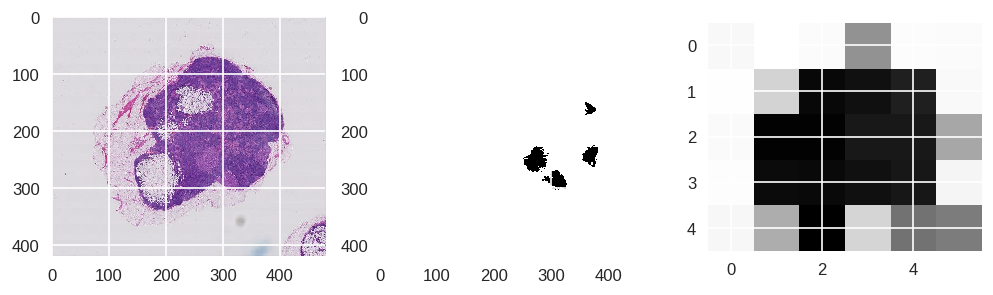

In [0]:
plt.figure(figsize = (10,20), dpi = 120)

plt.subplot(1, 3, 1)
plt.imshow(test_slide_image)

plt.subplot(1, 3, 2)
plt.imshow(test_mask_image)

plt.subplot(1, 3, 3)
plt.imshow(predictions)


In [0]:
#another example
test_slide_path2 = '/root/data/tumor_075.tif'
test_slide2 = open_slide(test_slide_path2)



In [0]:
#reading slide
test_slide_image2 = read_slide(test_slide2, 
                         x=0, 
                         y=0, 
                         level=7, 
                         width=test_slide.level_dimensions[7][0], 
                         height=test_slide.level_dimensions[7][1])



In [0]:
#level 7 dimensions
test_slide2.level_dimensions[7]

(704, 616)

In [0]:
#getting patches from slide at level 7
test_slide_patches2 = []
for j in range(0,test_slide2.level_dimensions[7][1],80):
  for i in range(0,test_slide2.level_dimensions[7][0],80):
    image = read_slide(test_slide2,i*128,j*128,level = 7, width = 80,height = 80)
    tissue_pixels = find_tissue_pixels(image)
    image = apply_mask(image, tissue_pixels, (255,0,0))
    test_slide_patches2.append(image)


In [0]:
#converting to numpy array
test_slide_patches2 = np.array(test_slide_patches2)

In [0]:
#getting predictions for each patch
predictions2 = model.predict(test_slide_patches2)

In [0]:
#removing last 9 predictions because those patches don't actually belong to the slide - there are 72 predictions for 80x80 patches taken of a 704x616 image
predictions2 = predictions2[:63]

In [0]:
predictions2.shape

(63, 1)

In [0]:
#reshaping to get original orientation of the slide image
predictions2 = predictions2.reshape((7,9))

In [0]:
test_mask_path2 = '/root/data/tumor_075_mask.tif'
test_mask2 = open_slide(test_mask_path2)

test_mask_image2 = read_slide(test_mask2, x = 0, y=0, level= 7, width = test_mask2.level_dimensions[7][0], height = test_mask2.level_dimensions[7][1])

test_mask_image2 = test_mask_image2[:,:,0]



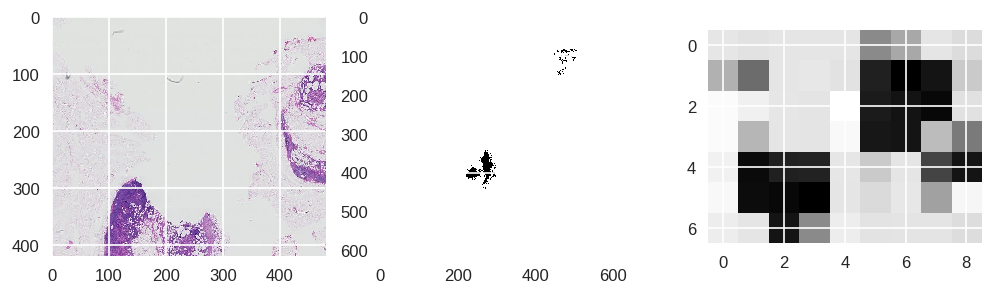

In [0]:
plt.figure(figsize = (10,20), dpi = 120)

plt.subplot(1, 3, 1)
plt.imshow(test_slide_image2)

plt.subplot(1, 3, 2)
plt.imshow(test_mask_image2)

plt.subplot(1, 3, 3)
plt.imshow(predictions2)


In [0]:
# create on Colab directory
model.save('model.h5')    
model_file = drive.CreateFile({'title' : 'model.h5'})
model_file.SetContentFile('model.h5')
model_file.Upload()

# download to google drive
drive.CreateFile({'id': model_file.get('id')})

GoogleDriveFile({'id': '1zVMKzKvw7YnXboF89_xqvnuqM0QXqlxD'})

In [0]:
model.save_weights('model_weights.h5')
weights_file = drive.CreateFile({'title' : 'model_weights.h5'})
weights_file.SetContentFile('model_weights.h5')
weights_file.Upload()
drive.CreateFile({'id': weights_file.get('id')})


GoogleDriveFile({'id': '1oJvvKblLgkyUr-F8p3xyCx1nLyfLaYe3'})